<h1>New York City Taxi Fare Prediction Kaggle Competition</h1>

<h3>Dependencies</h3>

In [1]:
import os
import numpy as np
import pandas as pd
import keras
import datetime
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense,Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


 <h3>Load the Dataset</h3>

In [2]:
df = pd.read_csv('train.csv',nrows=1000000)
df = shuffle(df)


df=df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
df=df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
df=df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
df=df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
# Remove possible outliers
df=df[(1 <= df['passenger_count']) & (df['passenger_count'] <= 6)]
df=df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]    
df=df[(df['dropoff_longitude'] != df['pickup_longitude'])]
df=df[(df['dropoff_latitude'] != df['pickup_latitude'])]

<h3>Preprocess the Data</h3>

<ul>
<li>Lambda functions</li>
<li>Euclidean Distance calculation</li>
<li>Latitude/Longitude Difference</li>
</ul>

In [3]:
def process(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['minute'] = df['pickup_datetime'].apply(lambda x: x.minute)
    df['second'] = df['pickup_datetime'].apply(lambda x: x.second)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    
    return df


def add_engineered(df):
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    weekday = df['weekday']
    hour = df['hour']

    jfk_lat = 40.639722
    jfk_lon = -73.778889
    ewr_lat = 40.6925 
    ewr_lon = -74.168611
    lga_lat = 40.77725 
    lga_lon = -73.872611

    pickup_jfk_latdiff = lat1 - jfk_lat
    pickup_jfk_londiff = lon1 - jfk_lon

    dropoff_jfk_latdiff = lat2 - jfk_lat
    dropoff_jfk_londiff = lon2 - jfk_lon


    pickup_ewr_latdiff = lat1 - ewr_lat
    pickup_ewr_londiff = lon1 - ewr_lon

    dropoff_ewr_latdiff = lat2 - ewr_lat
    dropoff_ewr_londiff = lon2 - ewr_lon


    pickup_lga_latdiff = lat1 - lga_lat
    pickup_lga_londiff = lon1 - lga_lon

    dropoff_lga_latdiff = lat2 - lga_lat
    dropoff_lga_londiff = lon2 - lga_lon

    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    euclidean = (latdiff ** 2 + londiff ** 2) ** 0.5    
    ploc = lat1 * lon1
    dloc = lat2 * lon2
    pd_pair = ploc * dloc
    day_hr = weekday * hour



    pickup_jfk = (pickup_jfk_latdiff ** 2 + pickup_jfk_londiff **2) ** 0.5
    dropoff_jfk = (dropoff_jfk_latdiff ** 2 + dropoff_jfk_londiff **2) ** 0.5

    pickup_ewr = (pickup_ewr_latdiff ** 2 + pickup_ewr_londiff **2) ** 0.5
    dropoff_ewr = (dropoff_ewr_latdiff ** 2 + dropoff_ewr_londiff **2) ** 0.5

    pickup_lga = (pickup_lga_latdiff ** 2 + pickup_lga_londiff **2) ** 0.5
    dropoff_lga = (dropoff_lga_latdiff ** 2 + dropoff_lga_londiff **2) ** 0.5

    df['latdiff'] = latdiff
    df['londiff'] = londiff
    df['euclidean'] = euclidean
    df['ploc'] = ploc
    df['dloc'] = dloc
    df['pd_pair'] = pd_pair
    df['day_hr'] = day_hr
    df['pickup_jfk_distance'] = pickup_jfk
    df['dropoff_jfk_distance'] = dropoff_jfk
    df['pickup_ewr_distance'] = pickup_ewr
    df['dropoff_ewr_distance'] = dropoff_ewr
    df['pickup_lga_distance'] = pickup_lga
    df['dropoff_lga_distance'] = dropoff_lga


    df = pd.get_dummies(df, columns=['weekday'])
    df = pd.get_dummies(df, columns=['month'])
    df = pd.get_dummies(df, columns=['hour'])
    
    return df

<h3>Apply the functions to the Dataset</h3>

In [4]:
df = process(df)
df = add_engineered(df)

<h3>We check the shape of the Dataset</h3>

In [5]:
df.shape

(964988, 68)

<h3>If there are duplicates in our Dataset we delete them</h3>

In [6]:
df = df.drop_duplicates()

<h3>We check to see if the Dataset contained Duplicates</h3>

In [7]:
df.shape

(964988, 68)

<h3>We drop all the rows that contain NaN values</h3>

In [8]:
df = df.dropna()

<h3>We check the formal of the Dataset</h3>

In [9]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
83682,2014-01-08 18:35:00.000000228,10.5,2014-01-08 18:35:00,-73.997740,40.746557,-73.975117,40.758650,1,2014,8,...,0,0,0,0,1,0,0,0,0,0
106820,2011-01-31 19:29:00.000000200,4.1,2011-01-31 19:29:00,-73.995055,40.744997,-74.005488,40.748258,1,2011,31,...,0,0,0,0,0,1,0,0,0,0
672145,2013-05-16 02:41:29.0000001,28.0,2013-05-16 02:41:29,-73.996989,40.737521,-73.965043,40.640897,1,2013,16,...,0,0,0,0,0,0,0,0,0,0
218782,2015-02-19 01:59:32.0000003,8.5,2015-02-19 01:59:32,-74.005623,40.732658,-73.980659,40.729767,1,2015,19,...,0,0,0,0,0,0,0,0,0,0
981947,2013-07-12 21:28:00.000000120,16.0,2013-07-12 21:28:00,-73.996025,40.729267,-73.988940,40.777577,1,2013,12,...,0,0,0,0,0,0,0,1,0,0


<h3>We split the Dataset to x_train and y_train</h3>

In [10]:
y_train = df['fare_amount']
y_train = np.array(y_train)
y_train = y_train.reshape(-1,1)

output_sc = MinMaxScaler()

x_train = df.drop(['key','fare_amount','pickup_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], axis=1)

<h3>We apply the MinMaxScaler in order to convert all the values of the dataset between 0 and 1</h3>

In [11]:
x_train = np.array(x_train)

sc = MinMaxScaler()

x_train = sc.fit_transform(x_train)

In [12]:
x_train.shape

(964988, 61)

<h3>Neural Network Model Architecture</h3>

In [13]:
model = Sequential()

model.add(Dense(units = 200,activation = 'relu',bias_initializer='zeros',use_bias=True, input_dim = x_train.shape[1]))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units = 400, activation = 'relu',use_bias=True,bias_initializer='zeros'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units = 100, activation = 'relu',use_bias=True,bias_initializer='zeros'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units = 120, activation = 'relu',use_bias=True,bias_initializer='zeros'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units = 140, activation = 'relu',use_bias=True,bias_initializer='zeros'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units = 80, activation = 'relu',use_bias=True,bias_initializer='zeros'))

model.add(Dense(units = 1))

<h3>Neural Network Optimizer</h3>

In [14]:
optimizer = Adam(lr=0.001)

<h3>Model compile with Adam Optimizer, using Mean Square Error as loss</h3>

In [15]:
model.compile(optimizer=optimizer,loss='mse',metrics=['mse','acc'])

<h3>Checkpoint to save only the model with the best validation_loss</h3>

In [16]:
filepath = 'best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_loss', verbose = 1, save_best_only=True)

<h3>Model train</h3>

In [17]:
history = model.fit(x_train,y_train,epochs=5,batch_size=1000,callbacks=[checkpoint],validation_split=0.8)

Train on 192997 samples, validate on 771991 samples
Epoch 1/5
192997/192997 [==============================] - 23s 118us/step - loss: 103.2367 - mean_squared_error: 103.2367 - acc: 0.0113 - val_loss: 72.5314 - val_mean_squared_error: 72.5314 - val_acc: 0.0162

Epoch 00001: val_loss improved from inf to 72.53144, saving model to best_model.hdf5
Epoch 2/5
192997/192997 [==============================] - 21s 107us/step - loss: 48.8499 - mean_squared_error: 48.8499 - acc: 0.0158 - val_loss: 48.1850 - val_mean_squared_error: 48.1850 - val_acc: 0.0214

Epoch 00002: val_loss improved from 72.53144 to 48.18499, saving model to best_model.hdf5
Epoch 3/5
192997/192997 [==============================] - 20s 106us/step - loss: 32.6100 - mean_squared_error: 32.6100 - acc: 0.0216 - val_loss: 29.5605 - val_mean_squared_error: 29.5605 - val_acc: 0.0259

Epoch 00003: val_loss improved from 48.18499 to 29.56052, saving model to best_model.hdf5
Epoch 4/5
192997/192997 [==============================] - 2

<h3>Plot train loss vs validation loss</h3>

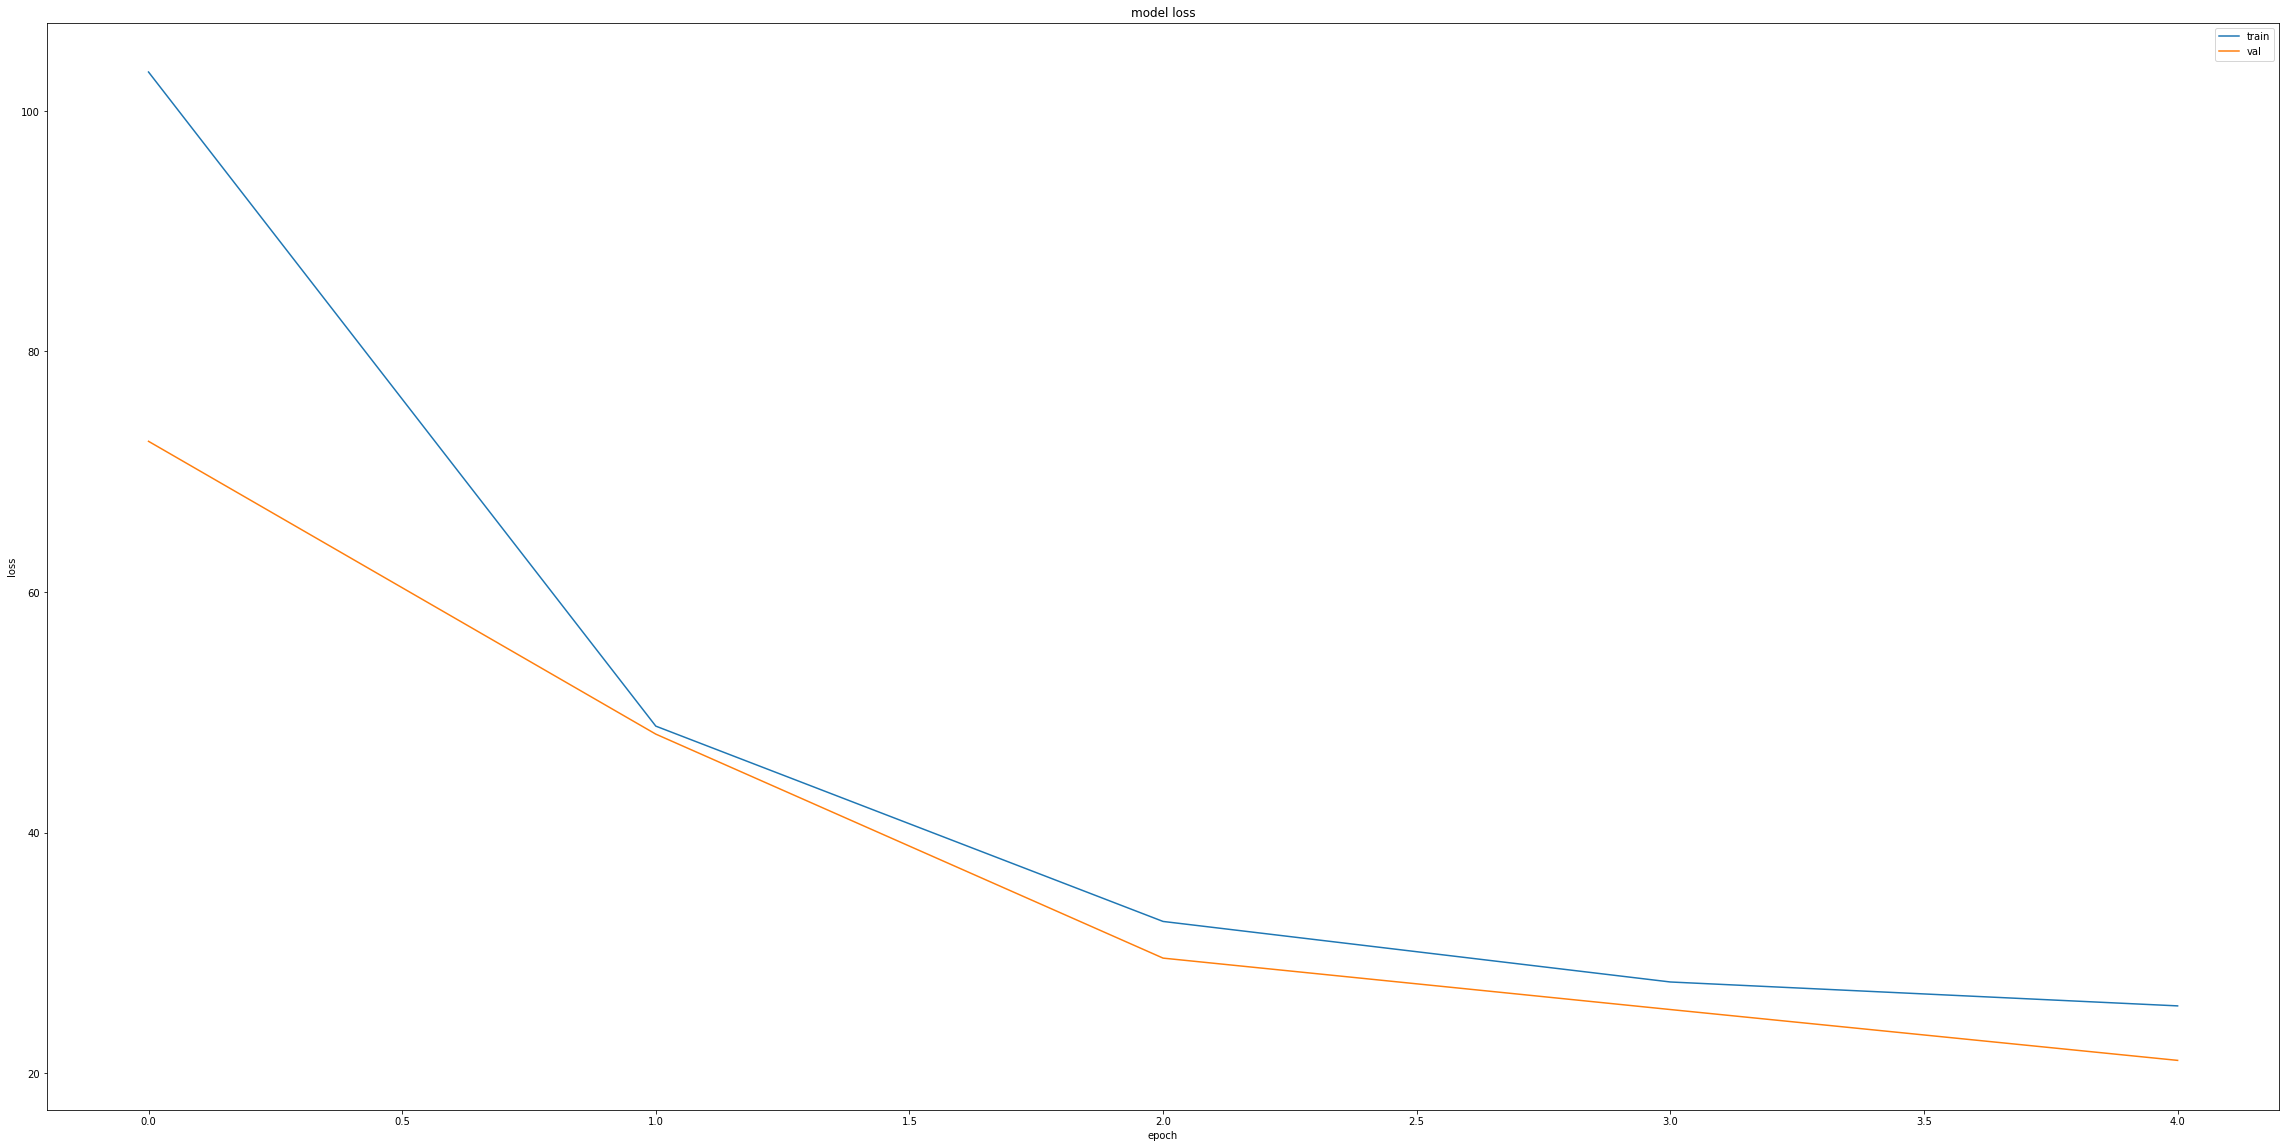

In [18]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(40,20))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig('loss.png')
    
    
plot_loss_accuracy(history)

<h3>Load the test Dataset</h3>

In [19]:
test_df = pd.read_csv('test.csv')

<h3>Apply the Processing Data functions to the test Dataset</h3>

In [20]:
test_df = process(test_df)
test_df = add_engineered(test_df)

<h3>Keep the key in order to create the submission file</h3>

In [21]:
key = test_df['key']

In [22]:
test_df.shape

(9914, 67)

<h3>Keep the train data of the test Dataset</h3>

In [23]:
x_test = test_df.drop(['key','pickup_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], axis=1)

x_test = x_test.astype('float64')

<h3>Use the Scaler that was used on the train dataset also to transform the data</h3>

In [24]:
x_test = sc.transform(x_test)

<h3>Keras Dependencies to load the best model that was saved from the callbacks</h3>

In [25]:
from keras.models import load_model

<h3>Load the best model and predict</h3>

In [26]:
best_model = load_model('best_model.hdf5')
submit = best_model.predict(x_test)

In [27]:
submit

array([[11.445358 ],
       [13.149996 ],
       [ 6.2170963],
       ...,
       [46.24572  ],
       [19.09284  ],
       [ 7.5926876]], dtype=float32)

<h3>Create the necessary format for the submission file and save it as csv</h3>

In [28]:
submit_final = pd.DataFrame({'fare_amount':submit[:,0]})
final = pd.concat([key,submit_final], axis=1)
final.to_csv('final_submit_best_model.csv',index= False)